# Ancient-to-Film GAN — CycleGAN Training Notebook
**Deliverable 2 | Implementation & Early Evaluation**

This notebook provides a minimal, end-to-end CycleGAN training scaffold for unpaired image-to-image translation.
- **Domain A**: Ancient paintings (`data/A`)
- **Domain B**: Film-style photos (`data/B`)

> Tip: Start with small images (128×128) and a few epochs to verify the pipeline.

In [5]:
!git clone https://github.com/samwu15/EEE6778_CTGAN_NHTS.git
%cd EEE6778_CTGAN_NHTS
!ls data

fatal: destination path 'EEE6778_CTGAN_NHTS' already exists and is not an empty directory.
/content/EEE6778_CTGAN_NHTS
A  B


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 0. Environment & Config

In [6]:

import os, random, itertools, time, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Paths
ROOT = Path("..").resolve() if (Path.cwd().name == "notebooks") else Path(".").resolve()
DATA_A = ROOT / "data" / "A"
DATA_B = ROOT / "data" / "B"
OUT_SAMPLES = ROOT / "results" / "samples"
OUT_CKPTS = ROOT / "results" / "checkpoints"
OUT_SAMPLES.mkdir(parents=True, exist_ok=True)
OUT_CKPTS.mkdir(parents=True, exist_ok=True)

# Hyperparameters (start small for demo)
IMG_SIZE = 128
BATCH_SIZE = 2
EPOCHS = 5
LR_G = 2e-4
LR_D = 2e-4
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0
NUM_WORKERS = 2


## 1. Dataset (Unpaired)

In [7]:

# --- Robust Dataset Setup (safe version) ---
import random
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# 若環境 cell 沒跑，給預設值
IMG_SIZE = globals().get("IMG_SIZE", 128)
BATCH_SIZE = globals().get("BATCH_SIZE", 2)
NUM_WORKERS = 0  # 👈 在 macOS / Windows 建議先用 0，避免多進程問題

# 根目錄推斷（Notebook通常在 notebooks/ 內）
ROOT = Path("..").resolve() if (Path.cwd().name == "notebooks") else Path(".").resolve()
DATA_A = ROOT / "data" / "A"
DATA_B = ROOT / "data" / "B"
print("ROOT =", ROOT)
print("DATA_A exists:", DATA_A.exists(), "| DATA_B exists:", DATA_B.exists())

# 檢查圖檔數量
def count_images(p):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    files = []
    for e in exts:
        files += list(p.glob(e))
    return len(files)

cntA = count_images(DATA_A)
cntB = count_images(DATA_B)
print(f"Found images -> A: {cntA} | B: {cntB}")
assert cntA > 0 and cntB > 0, "data/A 或 data/B 沒有找到圖檔（.jpg/.png）。"

# 資料轉換
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

class UnpairedImageDataset(Dataset):
    def __init__(self, dir_a, dir_b, transform=None):
        exts = {".jpg",".jpeg",".png",".JPG",".JPEG",".PNG"}
        self.paths_a = sorted([p for p in Path(dir_a).glob("*") if p.suffix in exts])
        self.paths_b = sorted([p for p in Path(dir_b).glob("*") if p.suffix in exts])
        self.transform = transform
        if len(self.paths_a) == 0 or len(self.paths_b) == 0:
            raise RuntimeError("請確認 data/A 與 data/B 內有圖檔（.jpg/.png）。")
    def __len__(self):
        return max(len(self.paths_a), len(self.paths_b))
    def __getitem__(self, idx):
        pa = self.paths_a[idx % len(self.paths_a)]
        pb = self.paths_b[random.randint(0, len(self.paths_b)-1)]
        ia, ib = Image.open(pa).convert("RGB"), Image.open(pb).convert("RGB")
        if self.transform:
            ia = self.transform(ia)
            ib = self.transform(ib)
        return ia, ib

ds = UnpairedImageDataset(DATA_A, DATA_B, transform=tfm)
# drop_last=True 可避免最後一個 batch 不足造成 shape 問題
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
print("✅ DataLoader 建立成功，dataset 長度 =", len(ds))



ROOT = /content/EEE6778_CTGAN_NHTS
DATA_A exists: True | DATA_B exists: True
Found images -> A: 2192 | B: 628
✅ DataLoader 建立成功，dataset 長度 = 2192


### Preview a mini-batch

Batch shapes: torch.Size([2, 3, 128, 128]) torch.Size([2, 3, 128, 128])


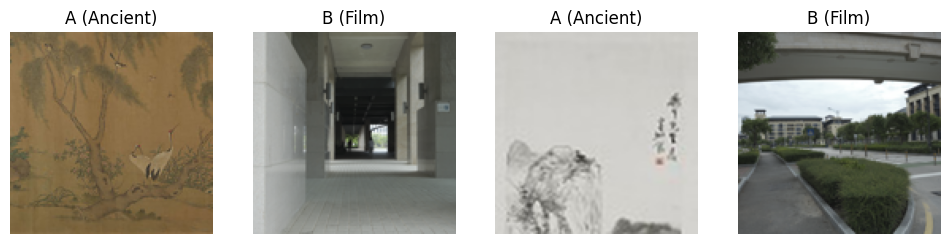

In [8]:

import matplotlib.pyplot as plt
import torch
import numpy

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0,1)

# 確保 dl 存在
if 'dl' not in globals():
    raise RuntimeError("DataLoader (dl) 尚未建立，請先執行 Dataset 的 cell。")

batch = next(iter(dl))
a_batch, b_batch = batch
print("Batch shapes:", a_batch.shape, b_batch.shape)

fig, axes = plt.subplots(1, a_batch.shape[0]*2, figsize=(12, 3))
for i in range(a_batch.shape[0]):
    axes[2*i].imshow(denorm(a_batch[i]).permute(1,2,0).numpy())
    axes[2*i].set_title("A (Ancient)"); axes[2*i].axis("off")
    axes[2*i+1].imshow(denorm(b_batch[i]).permute(1,2,0).numpy())
    axes[2*i+1].set_title("B (Film)"); axes[2*i+1].axis("off")
plt.show()



## 2. Models (Generator & Discriminator)

In [9]:

from src.cyclegan_min import GeneratorResnet, DiscriminatorPatchGAN

# Generators: A->B (G_AB) and B->A (G_BA)
G_AB = GeneratorResnet().to(DEVICE)
G_BA = GeneratorResnet().to(DEVICE)

# Discriminators: for domain B (D_B) and domain A (D_A)
D_B = DiscriminatorPatchGAN().to(DEVICE)
D_A = DiscriminatorPatchGAN().to(DEVICE)

# Init weights
def init_weights(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, torch.nn.InstanceNorm2d):
        if m.affine:
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.zeros_(m.bias)

G_AB.apply(init_weights); G_BA.apply(init_weights); D_A.apply(init_weights); D_B.apply(init_weights)

# Losses & Optimizers
mse = nn.MSELoss()
l1  = nn.L1Loss()
opt_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=LR_G, betas=(0.5, 0.999))
opt_D_A = torch.optim.Adam(D_A.parameters(), lr=LR_D, betas=(0.5, 0.999))
opt_D_B = torch.optim.Adam(D_B.parameters(), lr=LR_D, betas=(0.5, 0.999))

# Buffers for GAN targets
def real_like(x): return torch.ones_like(x, device=DEVICE)
def fake_like(x): return torch.zeros_like(x, device=DEVICE)


## 3. Training Loop (Toy Epochs)

In [ ]:

# ==== FAST TRAINING LOOP (Turbo) ====
from PIL import Image
from tqdm import tqdm
import torch

# 可調參數（越小越快）
SAVE_EVERY = 1000          # 每幾步存一次圖片（原本 50 → 300）
MAX_STEPS_PER_EPOCH = 400 # 每個 epoch 最多跑幾個 batch（None=不限制）
EPOCHS = globals().get("EPOCHS", 1)   # 建議 1~2 先驗證
# 若想再快：把 LAMBDA_ID 設 0.0（關掉 identity loss）
LAMBDA_ID =  0.0

# AMP（混合精度）可大幅提速（GPU）
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def save_sample(a, b_fake, step, out_dir=OUT_SAMPLES):
    # 與你原本相同的輸出格式
    def _denorm(x): return (x * 0.5 + 0.5).clamp(0,1)
    a = _denorm(a.detach().cpu())
    b_fake = _denorm(b_fake.detach().cpu())
    a0 = (a[0].permute(1,2,0).numpy()*255).astype("uint8")
    b0 = (b_fake[0].permute(1,2,0).numpy()*255).astype("uint8")
    Image.fromarray(a0).save(out_dir / f"step{step:06d}_A.png")
    Image.fromarray(b0).save(out_dir / f"step{step:06d}_AtoB.png")

step = 0
for epoch in range(1, EPOCHS+1):
    pbar = tqdm(dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for i, (a, b) in enumerate(pbar, start=1):
        # 限制每個 epoch 的步數 → 明顯縮短時間
        if MAX_STEPS_PER_EPOCH and i > MAX_STEPS_PER_EPOCH:
            break

        a = a.to(DEVICE, non_blocking=True)
        b = b.to(DEVICE, non_blocking=True)

        # --------------------
        #  Train Generators (AMP)
        # --------------------
        opt_G.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            b_fake = G_AB(a)
            a_rec  = G_BA(b_fake)
            a_fake = G_BA(b)
            b_rec  = G_AB(a_fake)

            # identity（可設 LAMBDA_ID=0.0 以提速）
            loss_id_a = l1(a_fake, b) * LAMBDA_ID
            loss_id_b = l1(b_fake, a) * LAMBDA_ID

            # adversarial
            pred_b = D_B(b_fake)
            pred_a = D_A(a_fake)
            loss_gan_ab = mse(pred_b, real_like(pred_b))
            loss_gan_ba = mse(pred_a, real_like(pred_a))

            # cycle-consistency
            loss_cyc_a = l1(a_rec, a) * LAMBDA_CYCLE
            loss_cyc_b = l1(b_rec, b) * LAMBDA_CYCLE

            loss_G = loss_id_a + loss_id_b + loss_gan_ab + loss_gan_ba + loss_cyc_a + loss_cyc_b

        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        # --------------------
        #  Train D_A (AMP)
        # --------------------
        opt_D_A.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            pred_real_a = D_A(a)
            pred_fake_a = D_A(a_fake.detach())
            loss_D_A = 0.5*(mse(pred_real_a, real_like(pred_real_a)) + mse(pred_fake_a, fake_like(pred_fake_a)))
        scaler.scale(loss_D_A).backward()
        scaler.step(opt_D_A)
        scaler.update()

        # --------------------
        #  Train D_B (AMP)
        # --------------------
        opt_D_B.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            pred_real_b = D_B(b)
            pred_fake_b = D_B(b_fake.detach())
            loss_D_B = 0.5*(mse(pred_real_b, real_like(pred_real_b)) + mse(pred_fake_b, fake_like(pred_fake_b)))
        scaler.scale(loss_D_B).backward()
        scaler.step(opt_D_B)
        scaler.update()

        step += 1
        if step % SAVE_EVERY == 0:
            save_sample(a, b_fake, step)

        pbar.set_postfix({
            "G": f"{loss_G.item():.3f}",
            "D_A": f"{loss_D_A.item():.3f}",
            "D_B": f"{loss_D_B.item():.3f}"
        })

    # 每個 epoch 存一次 checkpoint（足夠 D2 使用）
    torch.save({
        "G_AB": G_AB.state_dict(),
        "G_BA": G_BA.state_dict(),
        "D_A": D_A.state_dict(),
        "D_B": D_B.state_dict(),
        "epoch": epoch,
        "fast_mode": True
    }, OUT_CKPTS / f"cyclegan_epoch_{epoch:02d}.pt")
    print(f"[Epoch {epoch}] checkpoint saved.")

print("Training loop finished (FAST MODE).")


/tmp/ipython-input-4266462439.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Epoch 1/5:   0%|          | 0/1096 [00:00<?, ?it/s]/tmp/ipython-input-4266462439.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-4266462439.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-4266462439.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch 1/5:   1%|▏         | 15/1096 [03:06<3:48:05, 12.66s/it, G=9.011, D_A=0.402, D_B=0.511]

## 4. Inference Helper

In [ ]:

@torch.inference_mode()
def translate_image(path_in, path_out, ckpt=None, direction="A2B"):
    img = Image.open(path_in).convert("RGB")
    x = tfm(img).unsqueeze(0).to(DEVICE)
    if ckpt:
        state = torch.load(ckpt, map_location=DEVICE)
        G_AB.load_state_dict(state["G_AB"]); G_BA.load_state_dict(state["G_BA"])
    if direction == "A2B":
        y = G_AB(x)
    else:
        y = G_BA(x)
    y = denorm(y[0].cpu()).permute(1,2,0).numpy()
    Image.fromarray((y*255).astype("uint8")).save(path_out)
    return path_out

# Example:
# translate_image(ROOT/'data/A/sample.jpg', ROOT/'results/samples/sample_A2B.png', ckpt=ROOT/'results/checkpoints/cyclegan_epoch_01.pt')


## 5. Notes for Deliverable 2 Report


- Keep **EPOCHS small** (e.g., 3–5) and **IMG_SIZE=128** for a quick demo.
- Save a few outputs in `results/samples/` and insert them into your report.
- Record losses per epoch; optionally add a simple loss curve.
- Mention compute setup (CPU/GPU), and any training instability or artifacts observed.
- For interface (Step 3), load the latest checkpoint in `ui/app.py` and call `translate_image`.
